In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
def plt_show_cv2(img, cv_color=cv2.COLOR_BGR2RGB):
    plt.figure(figsize=(10, 10), facecolor="black")
    plt.imshow(cv2.cvtColor(img, cv_color))
    plt.axis('off')
    plt.show()

In [3]:
# from https://stackoverflow.com/questions/40895785/using-opencv-to-overlay-transparent-image-onto-another-image
def overlay_image(background, foreground):
    # normalize alpha channels from 0-255 to 0-1
    alpha_background = background[:,:,3] / 255.0
    alpha_foreground = foreground[:,:,3] / 255.0

    # set adjusted colors
    for color in range(0, 3):
        background[:,:,color] = alpha_foreground * foreground[:,:,color] + \
            alpha_background * background[:,:,color] * (1 - alpha_foreground)

    # set adjusted alpha and denormalize back to 0-255
    background[:,:,3] = (1 - (1 - alpha_foreground) * (1 - alpha_background)) * 255
    return background

#### Study

going to work with this illusion by [@AkiyoshiKitaoka](https://x.com/AkiyoshiKitaoka/status/1812708603826163940)

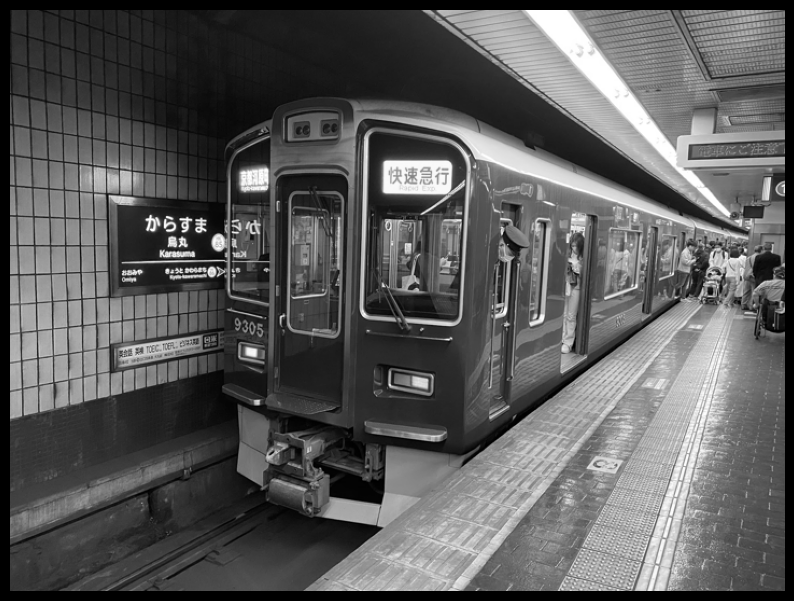

In [4]:
sample_path = "./sample/original.png"
sample_img = cv2.imread(sample_path)

sample_greyscale = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY)
sample_greyscale = cv2.cvtColor(sample_greyscale, cv2.COLOR_GRAY2BGRA)

plt_show_cv2(sample_greyscale)

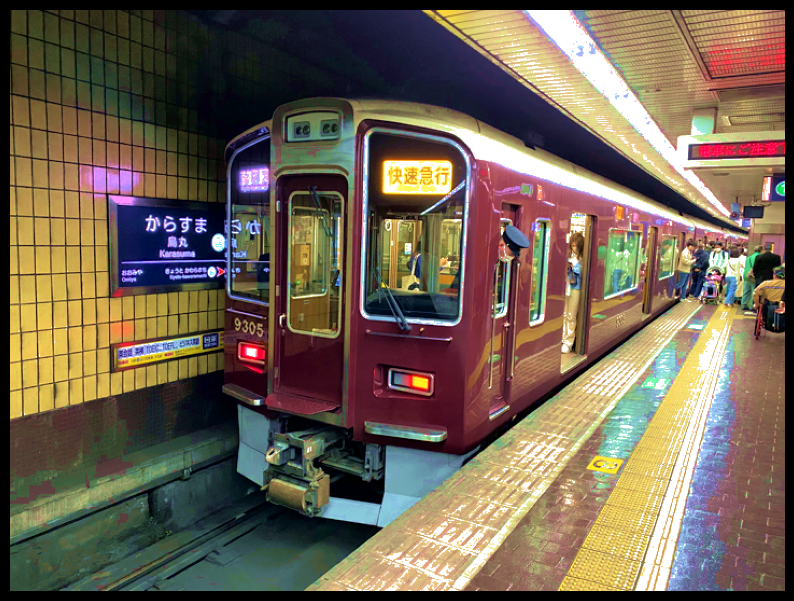

In [5]:
def add_contrast(img, c_level=50):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    l_hist = cv2.equalizeHist(l)
    # a_hist = cv2.equalizeHist(a)
    # b_hist = cv2.equalizeHist(b)

    hist = cv2.merge((l_hist, a, b))
    contrast = cv2.cvtColor(hist, cv2.COLOR_LAB2BGR)

    hsv = cv2.cvtColor(contrast, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)

    white_mask = cv2.inRange(hsv, (0, 0, 240), (100, 50, 255))
    white_mask = cv2.bitwise_and(img, img, mask=white_mask)


    s = cv2.add(s, c_level)
    s = np.clip(s, 0, 255)
    hsv = cv2.merge((h,s,v))
    
    result =cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return cv2.addWeighted(result, 1, white_mask, 1, 0)

sample_img_contrasted = add_contrast(sample_img, c_level=80)

plt_show_cv2(sample_img_contrasted)

In [6]:
def get_kmeans(img, k=10):
    sample_pixels = img.reshape((-1, 3))

    criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 10, 1.0)
    compactness, labels, centers = cv2.kmeans(data=sample_pixels.astype(np.float32), K=k, bestLabels=None, criteria=criteria, attempts=10, flags=cv2.KMEANS_RANDOM_CENTERS)

    kmeans_colors = centers[labels].reshape(-1, 3)
    sample_kmean_colors = kmeans_colors.reshape(img.shape)
    return sample_kmean_colors

# plt_show_cv2(sample_img_contrasted_kmeans.astype(np.uint8), cv2.COLOR_HSV2RGB)

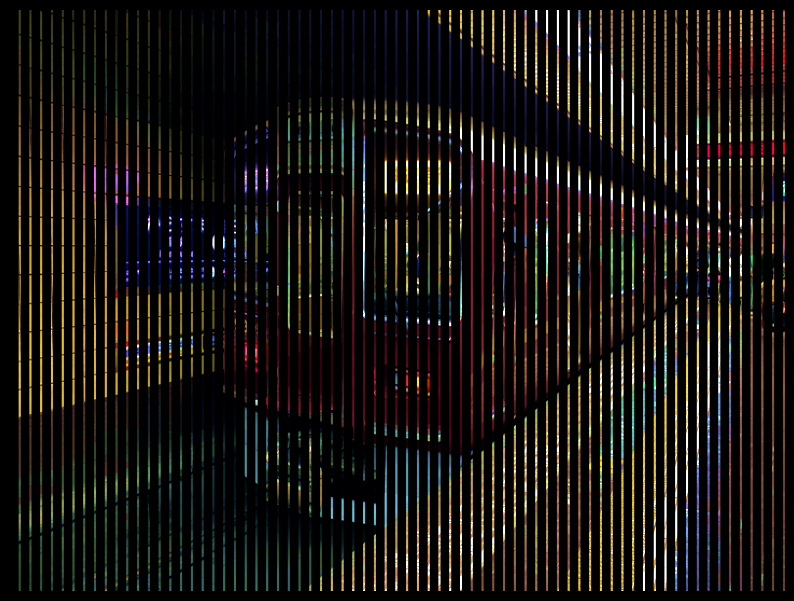

In [7]:
def make_color_lines(img, contrast=80, strip_width=6, strip_space=4):
    img_contrasted = add_contrast(img, c_level=contrast)

    h, w = img.shape[:2]
    img_alpha = np.zeros((h, w, 4), dtype=np.uint8)
    img_alpha[:, :, :3] = img_contrasted
    img_alpha[:, :, 3] = 255

    for x in range(0, w, strip_width + strip_space):
        img_alpha[:, x : x + strip_width, 3] = 0
    return img_alpha

plt_show_cv2(make_color_lines(sample_img, contrast=120, strip_width=8, strip_space=2), cv2.COLOR_BGRA2RGBA)

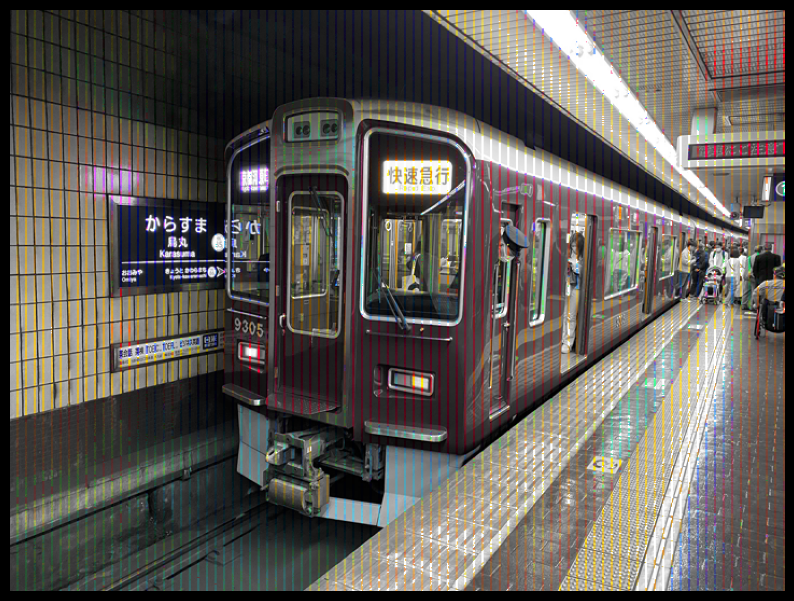

In [8]:
result = overlay_image(sample_greyscale, make_color_lines(sample_img, contrast=120, strip_width=6, strip_space=2))

plt_show_cv2(result, cv2.COLOR_BGRA2RGB)

#### Other Examples

In [12]:
brazil_path = "./images/brazil_nt.png"

brazil_img = cv2.imread(brazil_path)

print(brazil_img.shape)

brazil_greyscale = cv2.cvtColor(brazil_img, cv2.COLOR_BGR2GRAY)
brazil_greyscale = cv2.cvtColor(brazil_greyscale, cv2.COLOR_GRAY2BGRA)

(600, 720, 3)


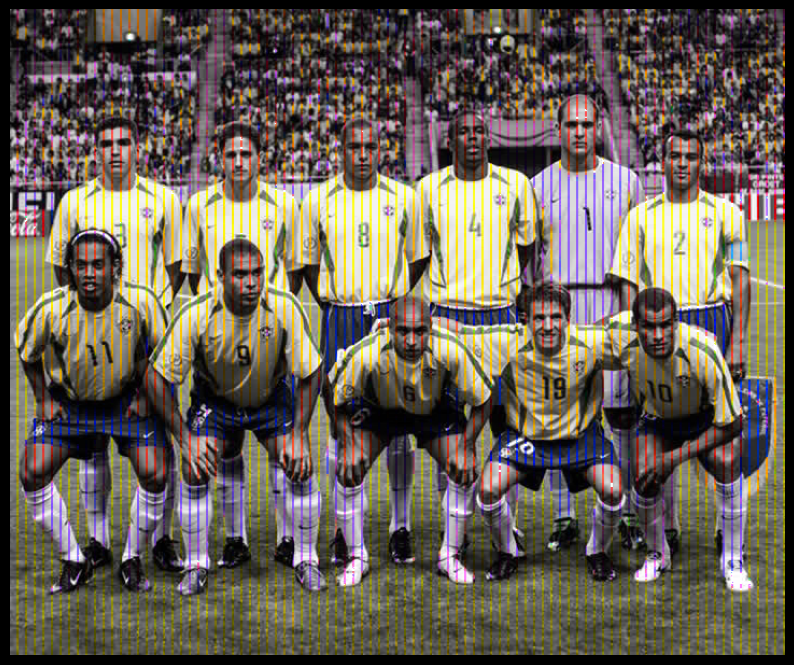

In [10]:
result = overlay_image(brazil_greyscale, make_color_lines(brazil_img, contrast=120, strip_width=6, strip_space=2))
plt_show_cv2(result, cv2.COLOR_BGRA2RGB)

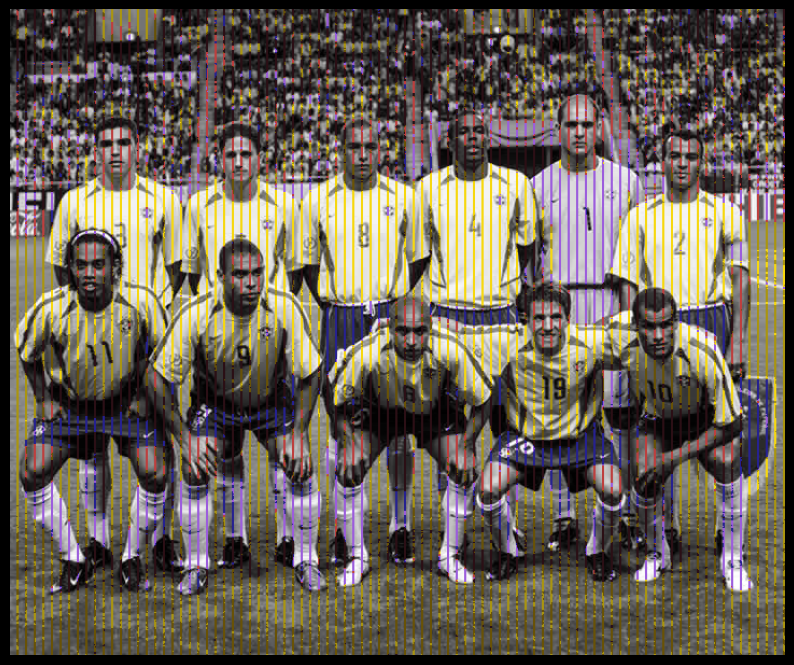

In [72]:
strip_width, strip_space = 6, 2
image_kmeans = add_contrast(brazil_img, c_level=120)

image_kmeans = get_kmeans(image_kmeans,k=7).astype(np.uint8)

h, w = image_kmeans.shape[:2]
img_alpha = np.zeros((h, w, 4), dtype=np.uint8)
img_alpha[:, :, :3] = image_kmeans
img_alpha[:, :, 3] = 255

for x in range(0, w, strip_width + strip_space):
    img_alpha[:, x : x + strip_width, 3] = 0

result_kmeans = overlay_image(brazil_greyscale, img_alpha)

plt_show_cv2(result_kmeans.astype(np.uint8))

[[ 38  33 145]
 [ 43  15  21]
 [105  82   5]
 [156  93 221]
 [170 149  15]
 [190  63  62]
 [247 216  14]]
Color Palette


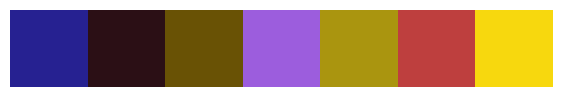

In [77]:
img_unique = cv2.cvtColor(image_kmeans, cv2.COLOR_BGR2RGB)
# plt_show_cv2(image_kmeans)
# img_unique = img_unique[:,:, :-1]

unique_colors = np.unique(img_unique.reshape(-1, img_unique.shape[2]), axis=0)
normalized_colors = [tuple(np.array(color)/255.0) for color in unique_colors]

print(unique_colors)

fig, ax = plt.subplots(figsize=(len(normalized_colors), 1))

for i, color in enumerate(normalized_colors):
    rect = plt.Rectangle((i,0), 1, 1, facecolor=color)
    ax.add_patch(rect)


print("Color Palette")
ax.set_xlim(0, len(normalized_colors))
ax.set_ylim(0, 1)
ax.axis('off')

plt.show()

#### save to video

In [13]:
# to save video
# video_path = "./images/ronaldinho.mp4"
# out_path = "./images/ronaldinho_illusion.mp4"

# cap = cv2.VideoCapture(video_path)

# # width, height = int(cap.get(3)), int(cap.get(4))
# width, height = 720, 600

# fourcc = cv2.VideoWriter_fourcc(*'XVID')
# out = cv2.VideoWriter(out_path, fourcc, 25, (width, height))

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break
#     frame_greyscale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     frame_greyscale_x = cv2.cvtColor(frame_greyscale, cv2.COLOR_GRAY2RGBA)
#     frame_greyscale_x = cv2.resize(frame_greyscale_x, (width, height))
    
#     frame_lines = make_color_lines(frame, contrast=120, strip_width=6, strip_space=2)    
#     frame_lines = cv2.resize(frame_lines, (width, height))

#     result = overlay_image(frame_greyscale_x, frame_lines)
#     result = cv2.cvtColor(result, cv2.COLOR_BGRA2BGR)
#     result = cv2.resize(result, (width, height))

#     out.write(result)

# cap.release()
# out.release()
# cv2.destroyAllWindows()

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
